In [104]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/1c/c3/17c6aa1dd5bc8cea5bf00d0c3a021a5dd1680c250861cc877a7e556e4b9b/tensorflow-2.14.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/cb/90/599c79a248dcae6935331113649de5d75427e320efde21b583648b498584/tensorflow_intel-2.14.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:
import json
import pandas as pd
import numpy as np

In [9]:
# Load the JSON data
with open('updated_teams_with_history_and_elo.json', 'r') as file:
    teams_data = json.load(file)

In [16]:
def top_5_elo_sum(players_elo):
    # Filter out None values and take top 5 player elos
    
    if len(players_elo) == 0:
        return [0]*4
    sum_elos = []
    for year in range(4):
        valid_elos = [player["elo"][year] for player in players_elo if player["elo"] != None]
        sum_elos.append(sum(sorted(valid_elos, reverse=True)[:min(5,len(valid_elos))]))
    return sum_elos

In [17]:
top_5_elos = [top_5_elo_sum(team_data["players"]) for team_data in teams_data]

In [37]:
teams_dict = {
    team['team_id']: {k: v for k, v in team.items() if k != 'team_id'}
    for team in teams_data
}

In [19]:
from datetime import datetime

In [109]:
# Extract features
team_ids = []
team_elos = []
top_5_elos = []
match_histories = []

for team_data in teams_data:
    team_ids.append(team_data["team_id"])
    team_elos.append(team_data["elo"] if team_data["elo"] != None else [0]*4)
    top_5_elos.append(top_5_elo_sum(team_data["players"]))
    # print(top_5_elo_sum(team_data["players"]))
    match_histories.extend([{**match} for match in team_data["match_history"]])

df_match_history = pd.DataFrame(match_histories)

df_match_history['eventTime'] = pd.to_datetime(df_match_history['eventTime'])
df_match_history['year'] = df_match_history['eventTime'].dt.year


players_elo_year = []
teams_elo_year = []
for index, match in df_match_history.iterrows():
    team = teams_dict[match['Team_id']]
    
    opponent_team_elo = teams_dict[match['Opponent_team']]['elo'][match['year']-2020] if match['Opponent_team'] in teams_dict.keys() else 0
    team_elo = team['elo'][match['year']-2020]
    teams_elo_year.append(team_elo/max(opponent_team_elo+team_elo,1))
    
    opponent_players_elo = top_5_elo_sum(teams_dict[match['Opponent_team']]['players'])[match['year']-2020] if match['Opponent_team'] in teams_dict.keys() else 0
    team_elo = team['elo'][match['year']-2020]
    player_elo = top_5_elo_sum(team["players"])[match['year']-2020]
    players_elo_year.append(player_elo/max(player_elo+opponent_players_elo,1))
        
            
df_match_history['players_elo'] = players_elo_year
df_match_history['team_elo'] = teams_elo_year
            
match_year = df_match_history['year']            
            
# Drop the 'Result' column since it's our target variable
X_features = df_match_history.drop(columns=["Result","eventTime","year","Team_id","Opponent_team","LeagueId"])
# # X_features = df_match_history.drop(columns=["eventTime"])

# Extract the target variable 'Result'
y_target = df_match_history["Result"]

# # Add team elo and top 5 player elos to the features DataFrame
# X_features["team_elo"] = X_features["Team_id"].map(dict(zip(team_ids, team_elos)))
# X_features["top_5_player_elo_sum"] = X_features["Team_id"].map(dict(zip(team_ids, top_5_elos)))



In [95]:
df_match_history.head()

,Team_id,Opponent_team,eventTime,inhibKills,LeagueId,towerKills,baronKills,dragonKills,Gold_per_min,KA_per_min,...,deaths_15,Result,GD_15,GPMD,towerKillsD_15,dragonKillsD_15,KAD_15,year,players_elo,team_elo
0,107582169874155554,107582150625414483,2022-01-27 02:34:42.132000+00:00,0,107582133359724496,3,0,2,1716.541432,1.287975,...,8,0,0.525560,0.483889,0.0,0.0,0.565217,2022,0.500659,0.511484
1,107582169874155554,107582181197106556,2022-01-29 02:46:39.720000+00:00,0,107582133359724496,2,1,0,1665.178829,1.260286,...,4,0,0.452412,0.473538,0.0,0.0,0.000000,2022,0.715656,0.497904
2,107582169874155554,107582157086477662,2022-03-03 02:50:43.077000+00:00,1,107582133359724496,6,0,2,1857.386656,1.299168,...,4,0,0.497063,0.488944,0.5,0.5,0.428571,2022,0.495296,0.445548
3,107582169874155554,107582181197106556,2022-03-10 00:20:35.584000+00:00,0,107582133359724496,1,0,2,1410.605115,0.394261,...,0,0,0.469835,0.431566,0.0,0.5,1.000000,2022,0.715656,0.497904
4,107582169874155554,107582181197106556,2022-03-10 01:30:30.971000+00:00,0,107582133359724496,2,0,3,1613.601659,0.952338,...,1,0,0.524132,0.473885,0.0,1.0,0.700000,2022,0.715656,0.497904


In [110]:
X_features.head()

,inhibKills,towerKills,baronKills,dragonKills,Gold_per_min,KA_per_min,deaths_per_min,game_length,Gold_15,towerKills_15,dragonKills_15,KA_15,deaths_15,GD_15,GPMD,towerKillsD_15,dragonKillsD_15,KAD_15,players_elo,team_elo
0,0,3,0,2,1716.541432,1.287975,0.630285,36.491400,27460,0,0,26,8,0.525560,0.483889,0.0,0.0,0.565217,0.500659,0.511484
1,0,2,1,0,1665.178829,1.260286,0.498863,38.086600,21191,0,0,0,4,0.452412,0.473538,0.0,0.0,0.000000,0.715656,0.497904
2,1,6,0,2,1857.386656,1.299168,0.768896,37.716433,24965,1,1,9,4,0.497063,0.488944,0.5,0.5,0.428571,0.495296,0.445548
3,0,1,0,2,1410.605115,0.394261,0.545900,32.973083,21455,0,1,3,0,0.469835,0.431566,0.0,0.5,1.000000,0.715656,0.497904
4,0,2,0,3,1613.601659,0.952338,0.463959,40.951867,24684,0,2,7,1,0.524132,0.473885,0.0,1.0,0.700000,0.715656,0.497904


0        0
1        0
2        0
3        0
4        0
        ..
47312    1
47313    1
47314    1
47315    1
47316    1
Name: Result, Length: 47317, dtype: int64

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

# Normalize the features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implement a Random Forest classifier
clf = RandomForestClassifier(n_estimators=500, random_state=42)

# Train the model on the training data
clf.fit(X_train_scaled, y_train)

# Predict the results on the test set
y_pred = clf.predict(X_test)
print(y_pred[:20])
# Evaluate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
accuracy



C:\Users\tqdat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


0.5004226542688082

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # <-- Import this
from sklearn.metrics import accuracy_score

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

# Implement a Logistic Regression classifier
clf = LogisticRegression(max_iter=2000, random_state=42)  # <-- Change this line

# Train the model on the training data
clf.fit(X_train, y_train)

# Predict the results on the test set
y_pred = clf.predict(X_test)
print(y_pred[:20])

# Evaluate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
accuracy


[1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1]


0.5236686390532544

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=42)
# Normalize the features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Assuming y_train is one-hot encoded for two classes (win for team A, win for team B)
])
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/20


C:\Users\tqdat\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1198/1198 [==============================] - 3s 2ms/step - loss: 0.3484 - accuracy: 0.8936 - val_loss: 0.3083 - val_accuracy: 0.9040
Epoch 2/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3177 - accuracy: 0.9048 - val_loss: 0.3004 - val_accuracy: 0.9056
Epoch 3/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3125 - accuracy: 0.9069 - val_loss: 0.2958 - val_accuracy: 0.9070
Epoch 4/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3048 - accuracy: 0.9082 - val_loss: 0.2920 - val_accuracy: 0.9070
Epoch 5/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3014 - accuracy: 0.9089 - val_loss: 0.2896 - val_accuracy: 0.9080
Epoch 6/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3018 - accuracy: 0.9087 - val_loss: 0.2875 - val_accuracy: 0.9091
Epoch 7/20
1198/1198 [==============================] - 3s 2ms/step - loss: 0.2983 - accuracy: 0.9100 - val_loss: 0.2885 - val_accuracy: 0.9077
Epo

In [125]:
X_train.head()

,inhibKills,towerKills,baronKills,dragonKills,Gold_per_min,KA_per_min,deaths_per_min,game_length,Gold_15,towerKills_15,dragonKills_15,KA_15,deaths_15,GD_15,GPMD,towerKillsD_15,dragonKillsD_15,KAD_15,players_elo,team_elo
24263,1,10,1,3,2106.308500,2.596006,0.247239,24.268050,27977,2,2,21,3,0.550728,0.581194,1.0,1.0,0.724138,0.376501,0.504654
31768,1,7,2,3,1854.104079,1.540612,0.220087,45.436500,23435,0,0,0,3,0.476583,0.524013,0.0,0.0,0.000000,0.834788,-0.176922
9141,2,10,2,4,1942.261563,1.212831,0.375400,34.629733,25832,1,1,8,1,0.530268,0.549380,1.0,0.5,0.727273,0.521218,0.594554
23912,0,3,1,3,1611.717674,1.378031,0.468531,36.283650,22935,0,2,14,1,0.492273,0.463806,0.0,1.0,0.777778,0.000000,0.520506
4745,0,5,0,2,1626.959766,0.609066,0.522056,34.479033,23899,1,2,7,3,0.501700,0.465137,1.0,1.0,0.437500,0.499268,0.468147


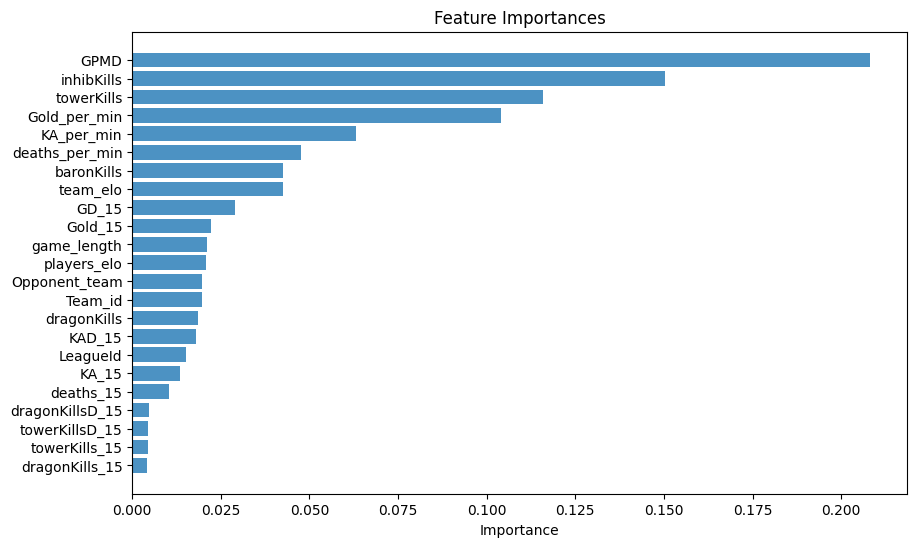

In [112]:
import matplotlib.pyplot as plt
feature_importances_dict = {feature: importance for feature, importance in zip(list(X_train.columns), clf.feature_importances_)}


sorted_features = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_features)
plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center', alpha=0.8)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Display the feature with the highest importance at the top
plt.show()

In [50]:
match_key = teams_data[0]["match_history"][0].keys()

In [168]:
# Helper function to create a feature vector for a given team ID
def create_feature_vector(team_id1, team_id2):
    for data in teams_data:
        
        if team_id1 == data["team_id"]:
            
            # for game in data["match_history"]:
                
    
            feature_vector = {}
        
            # Extract all matches between the two teams
            matches = [match for match in data["match_history"] if match["Opponent_team"] == team_id2]
            
            if not matches:
                zero_stats = list(X_features.columns)  # Get the column names from the DataFrame
                zero_match = {key: 0 for key in zero_stats}
                opponent_players_elo = top_5_elo_sum(teams_dict[team_id2]['players'])[3] if team_id2 in teams_dict.keys() else 0
                player_elo = top_5_elo_sum(data["players"])[3]
                zero_match["players_elo"] = player_elo/max(player_elo+opponent_players_elo,1)
                
                opponent_team_elo = teams_dict[team_id2]['elo'][3] if team_id2 in teams_dict.keys() else 0
                team_elo = data["elo"][3]
                zero_match["team_elo"] = team_elo/(team_elo+opponent_team_elo)
                df_to_predict = pd.DataFrame([zero_match])
                return df_to_predict
            # Initialize a dictionary to store the sum of each statistic
            stats_sum = {k: 0 for k in matches[0].keys() if k not in ["team_elo","players_elo","Result", "eventTime", "year", "Team_id", "Opponent_team", "LeagueId"]}
            
            # # Extract latest match history details excluding "Result"
            # latest_match = [match for match in data["match_history"] if match["Opponent_team"] == team_id2]
            # latest_match_features = {k: v for match in latest_match for k, v in match.items() if k not in ["Result","eventTime","year","Team_id","Opponent_team","LeagueId"]}

            
            
            # Iterate over matches and accumulate the statistics
            for match in matches:
                for key in stats_sum.keys():
                    stats_sum[key] += match[key]

            # Compute the average for each statistic
            average_stats = {k: v / len(matches) for k, v in stats_sum.items()}
            
            
            
            # Merge with the feature vector
            feature_vector.update(average_stats)
            # if len(feature_vector.keys()) == 0:
            #     feature_vector = {k: 0 for k in match_key if k not in ["Result","eventTime","year","Team_id","Opponent_team","LeagueId"]} 
            opponent_players_elo = top_5_elo_sum(teams_dict[team_id2]['players'])[3] if team_id2 in teams_dict.keys() else 0
            player_elo = top_5_elo_sum(data["players"])[3]
            feature_vector["players_elo"] = player_elo/max(player_elo+opponent_players_elo,1)
            
            opponent_team_elo = teams_dict[team_id2]['elo'][3] if team_id2 in teams_dict.keys() else 0
            team_elo = data["elo"][3]
            feature_vector["team_elo"] = team_elo/(team_elo+opponent_team_elo)
            df_to_predict = pd.DataFrame([feature_vector])
    return scaler.transform(df_to_predict)



In [170]:
create_feature_vector("105504044166670507","98767991853197861")

,inhibKills,towerKills,baronKills,dragonKills,Gold_per_min,KA_per_min,deaths_per_min,game_length,Gold_15,towerKills_15,dragonKills_15,KA_15,deaths_15,GD_15,GPMD,towerKillsD_15,dragonKillsD_15,KAD_15,players_elo,team_elo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.468055,0.221871


In [191]:
def predict_match(team1_id, team2_id):    
    # Create feature vectors for the two provided teams
    # team_1_vector = create_feature_vector("99566404852189289","107251295460371069")
    team_1_vector = create_feature_vector(team1_id,team2_id)
    team_2_vector = create_feature_vector(team2_id,team1_id)
    
    # Convert to DataFrame for prediction
    df_predict1 = pd.DataFrame(team_1_vector)
    df_predict2 = pd.DataFrame(team_2_vector)
    # Predict using the trained model
    # predictions = clf.predict(df_predict)
    predictions = model.predict(df_predict1),model.predict(df_predict2)
    # predictions
    
    predicted_classes = np.argmax(predictions, axis=0)
    print(predictions)
    return [team1_id, team2_id][predicted_classes[0][0]]

In [192]:
predict_match("98767991853197861","99566404852189289")

1/1 [==============================] - 0s 37ms/step
(array([[0.5463765]], dtype=float32), array([[0.4294728]], dtype=float32))


'98767991853197861'

In [194]:
model.save('predict_match_model.keras')

In [195]:
from joblib import dump
dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [196]:
zero_stats = list(X_features.columns)

In [197]:
print(zero_stats)

['inhibKills', 'towerKills', 'baronKills', 'dragonKills', 'Gold_per_min', 'KA_per_min', 'deaths_per_min', 'game_length', 'Gold_15', 'towerKills_15', 'dragonKills_15', 'KA_15', 'deaths_15', 'GD_15', 'GPMD', 'towerKillsD_15', 'dragonKillsD_15', 'KAD_15', 'players_elo', 'team_elo']
